In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
from PIL import Image
import torch
import seaborn as sns
sns.set()
from pathlib import Path
import numpy as np
from tqdm.notebook import tqdm
from model import MultiModalTransformer
from data import dataloaders
from utils import plot_attention

device = 'cpu'
root = Path('/mnt/hdd/data/MMMedViT_data')

In [3]:
# !pip uninstall cairosvg

In [4]:
EXPERIMENTS = [
    # ['lab'],
    # ['med'],
    # ['cxr'],
    # ['ecg'],
    ['lab','med','cxr','ecg']
]

/mnt/ssd/anaconda3/envs/cfm/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.p

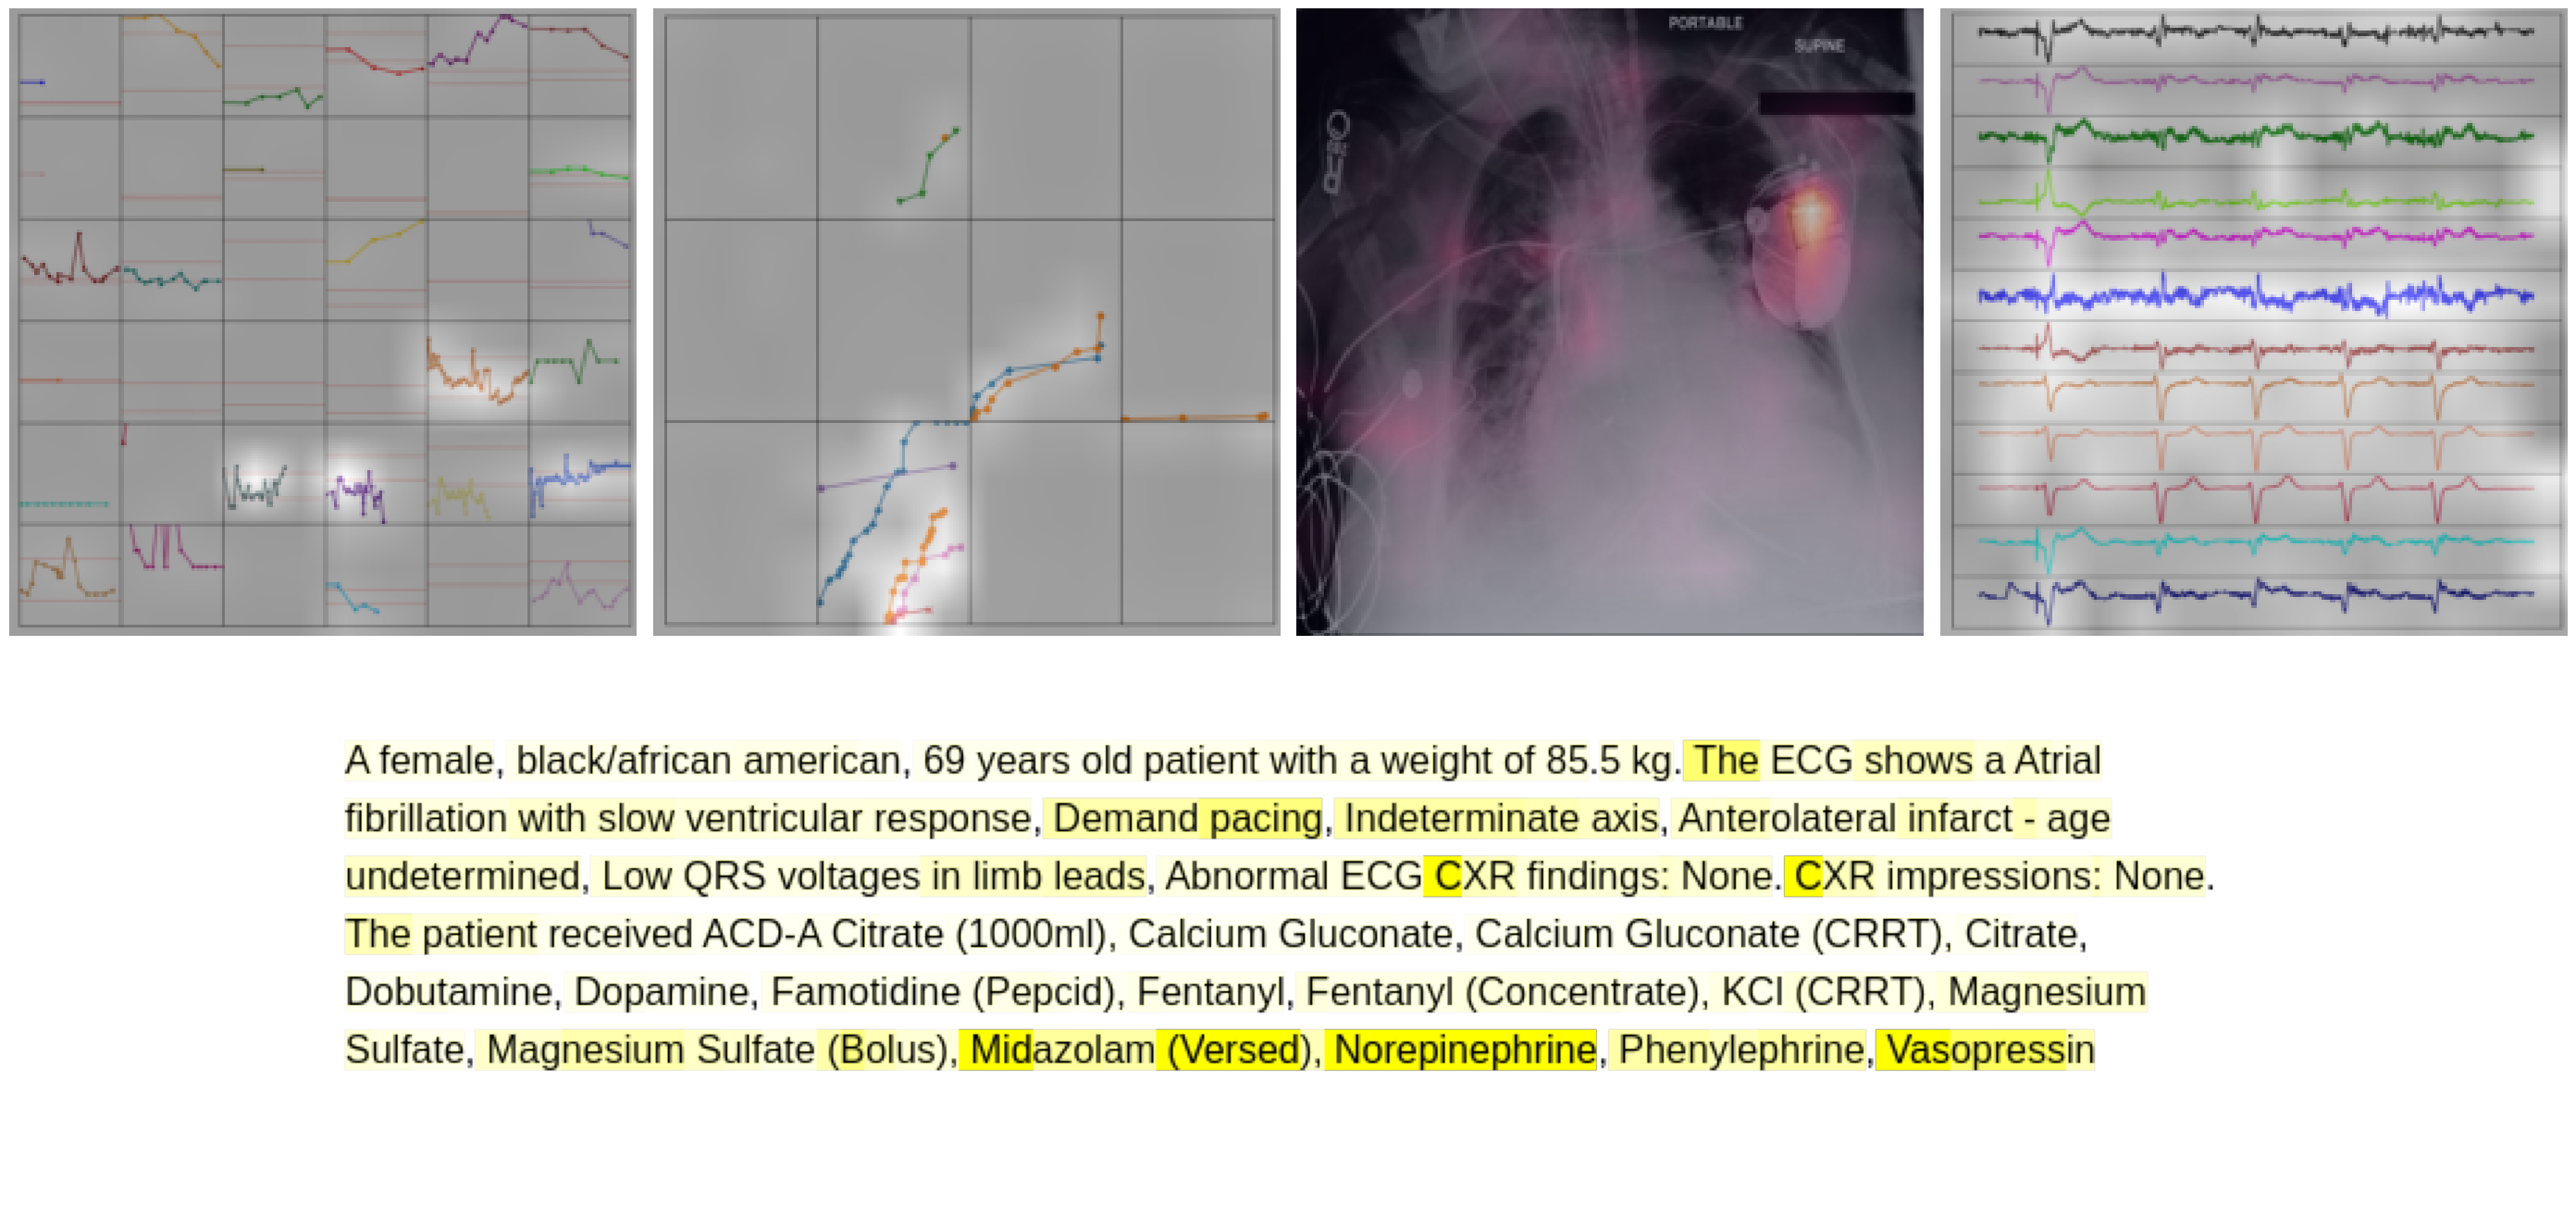

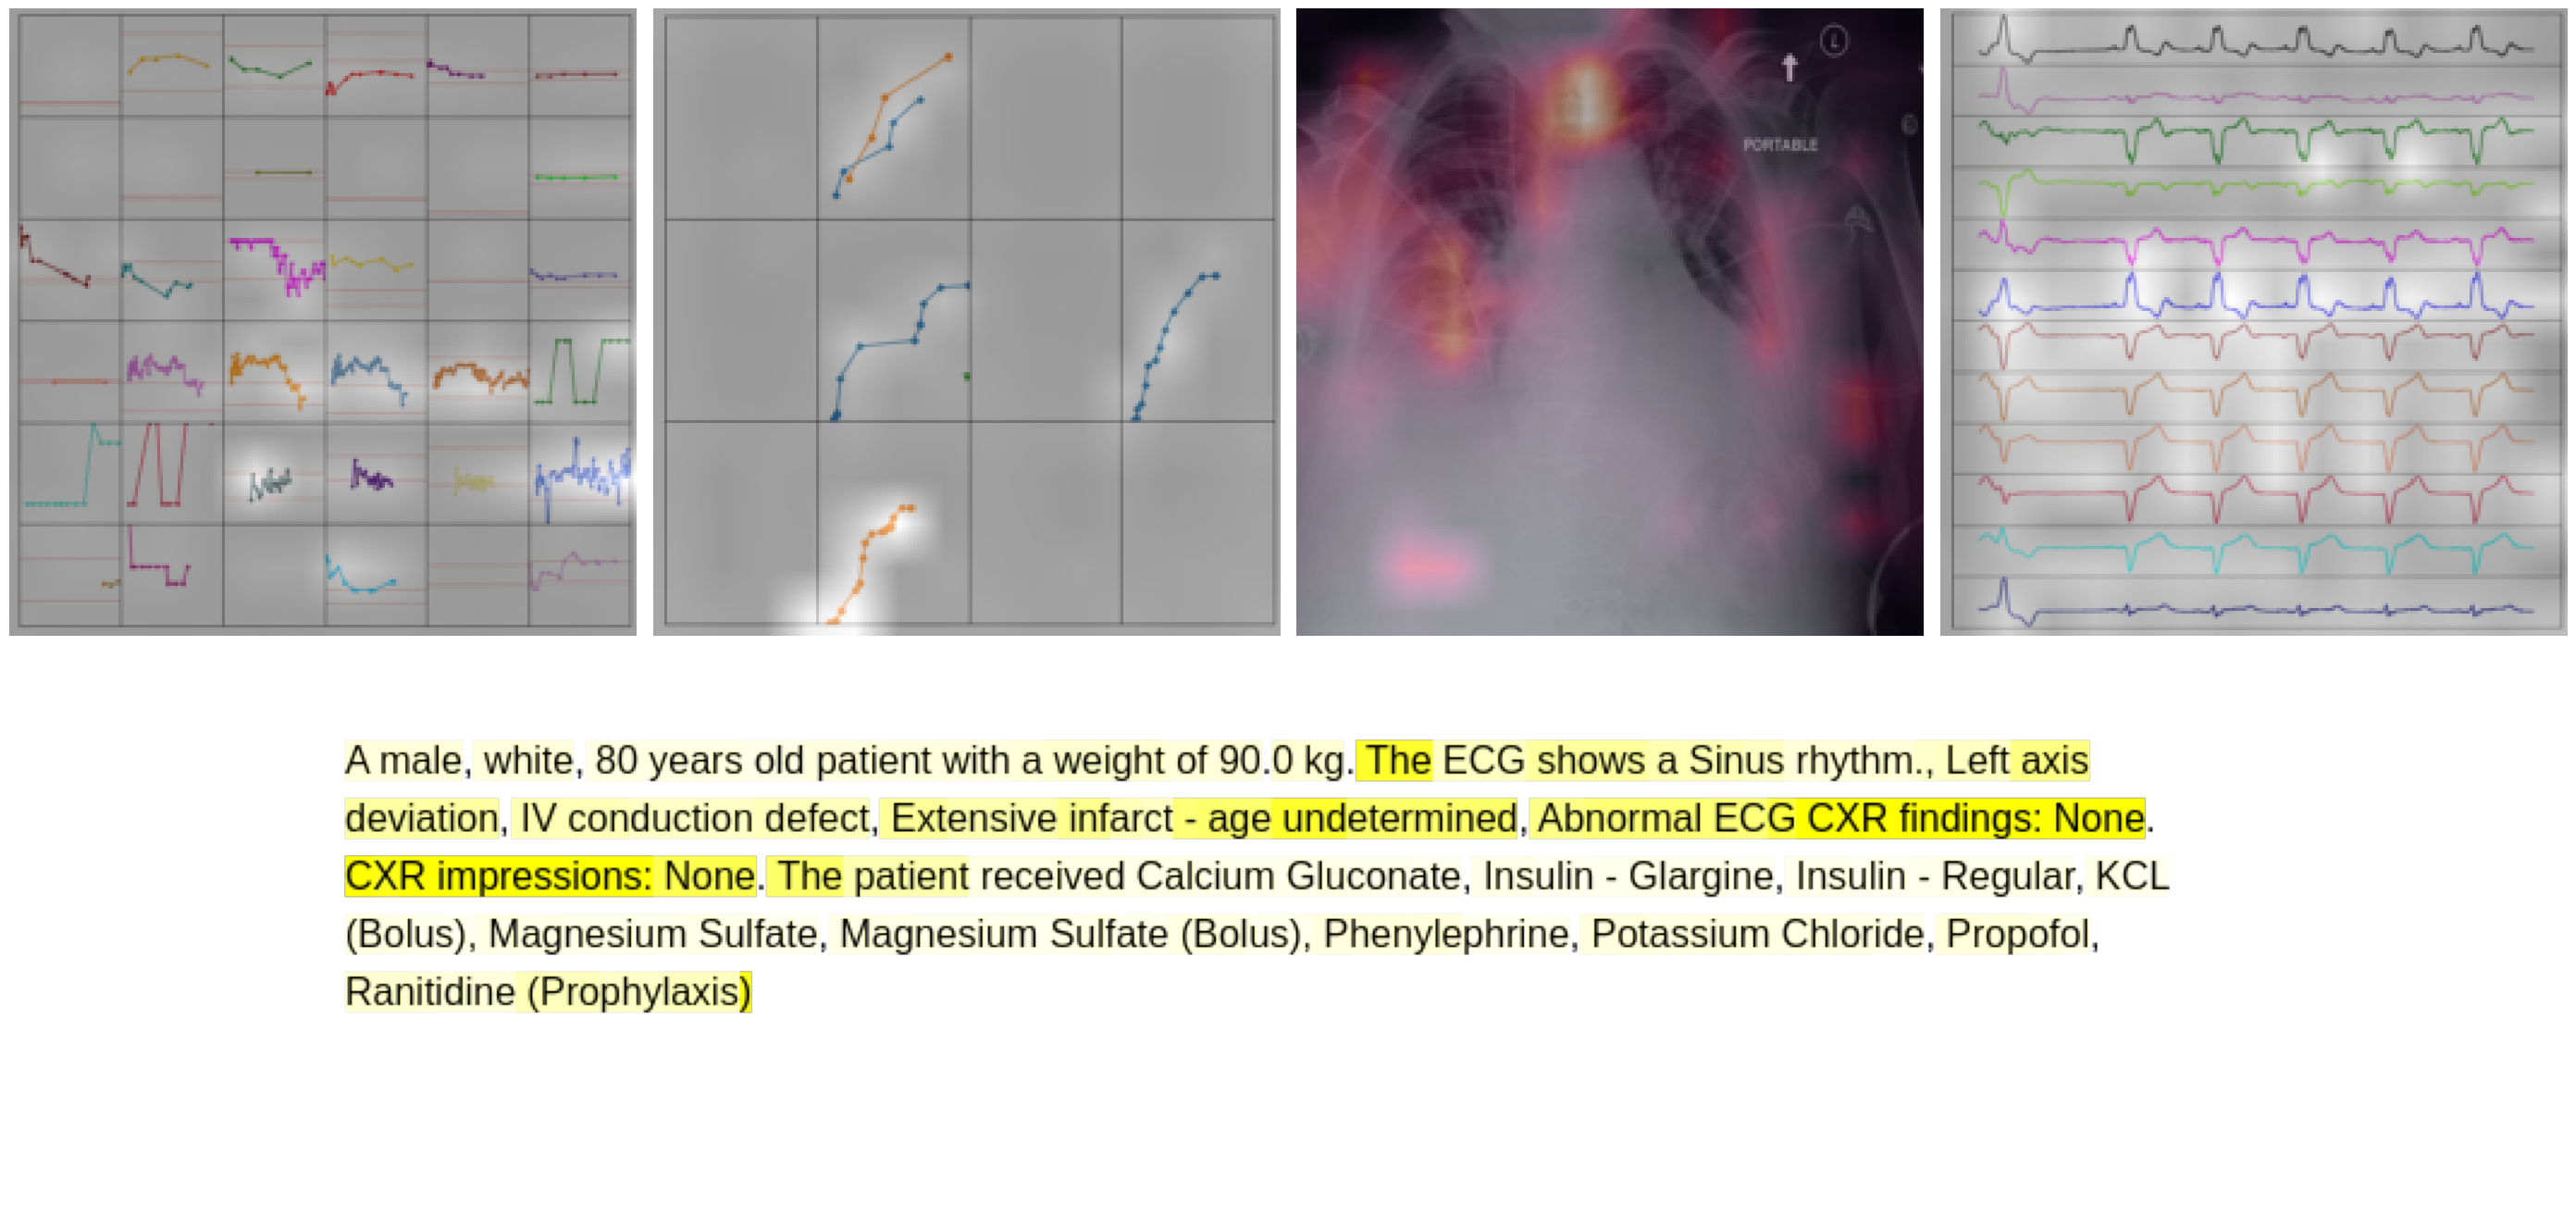

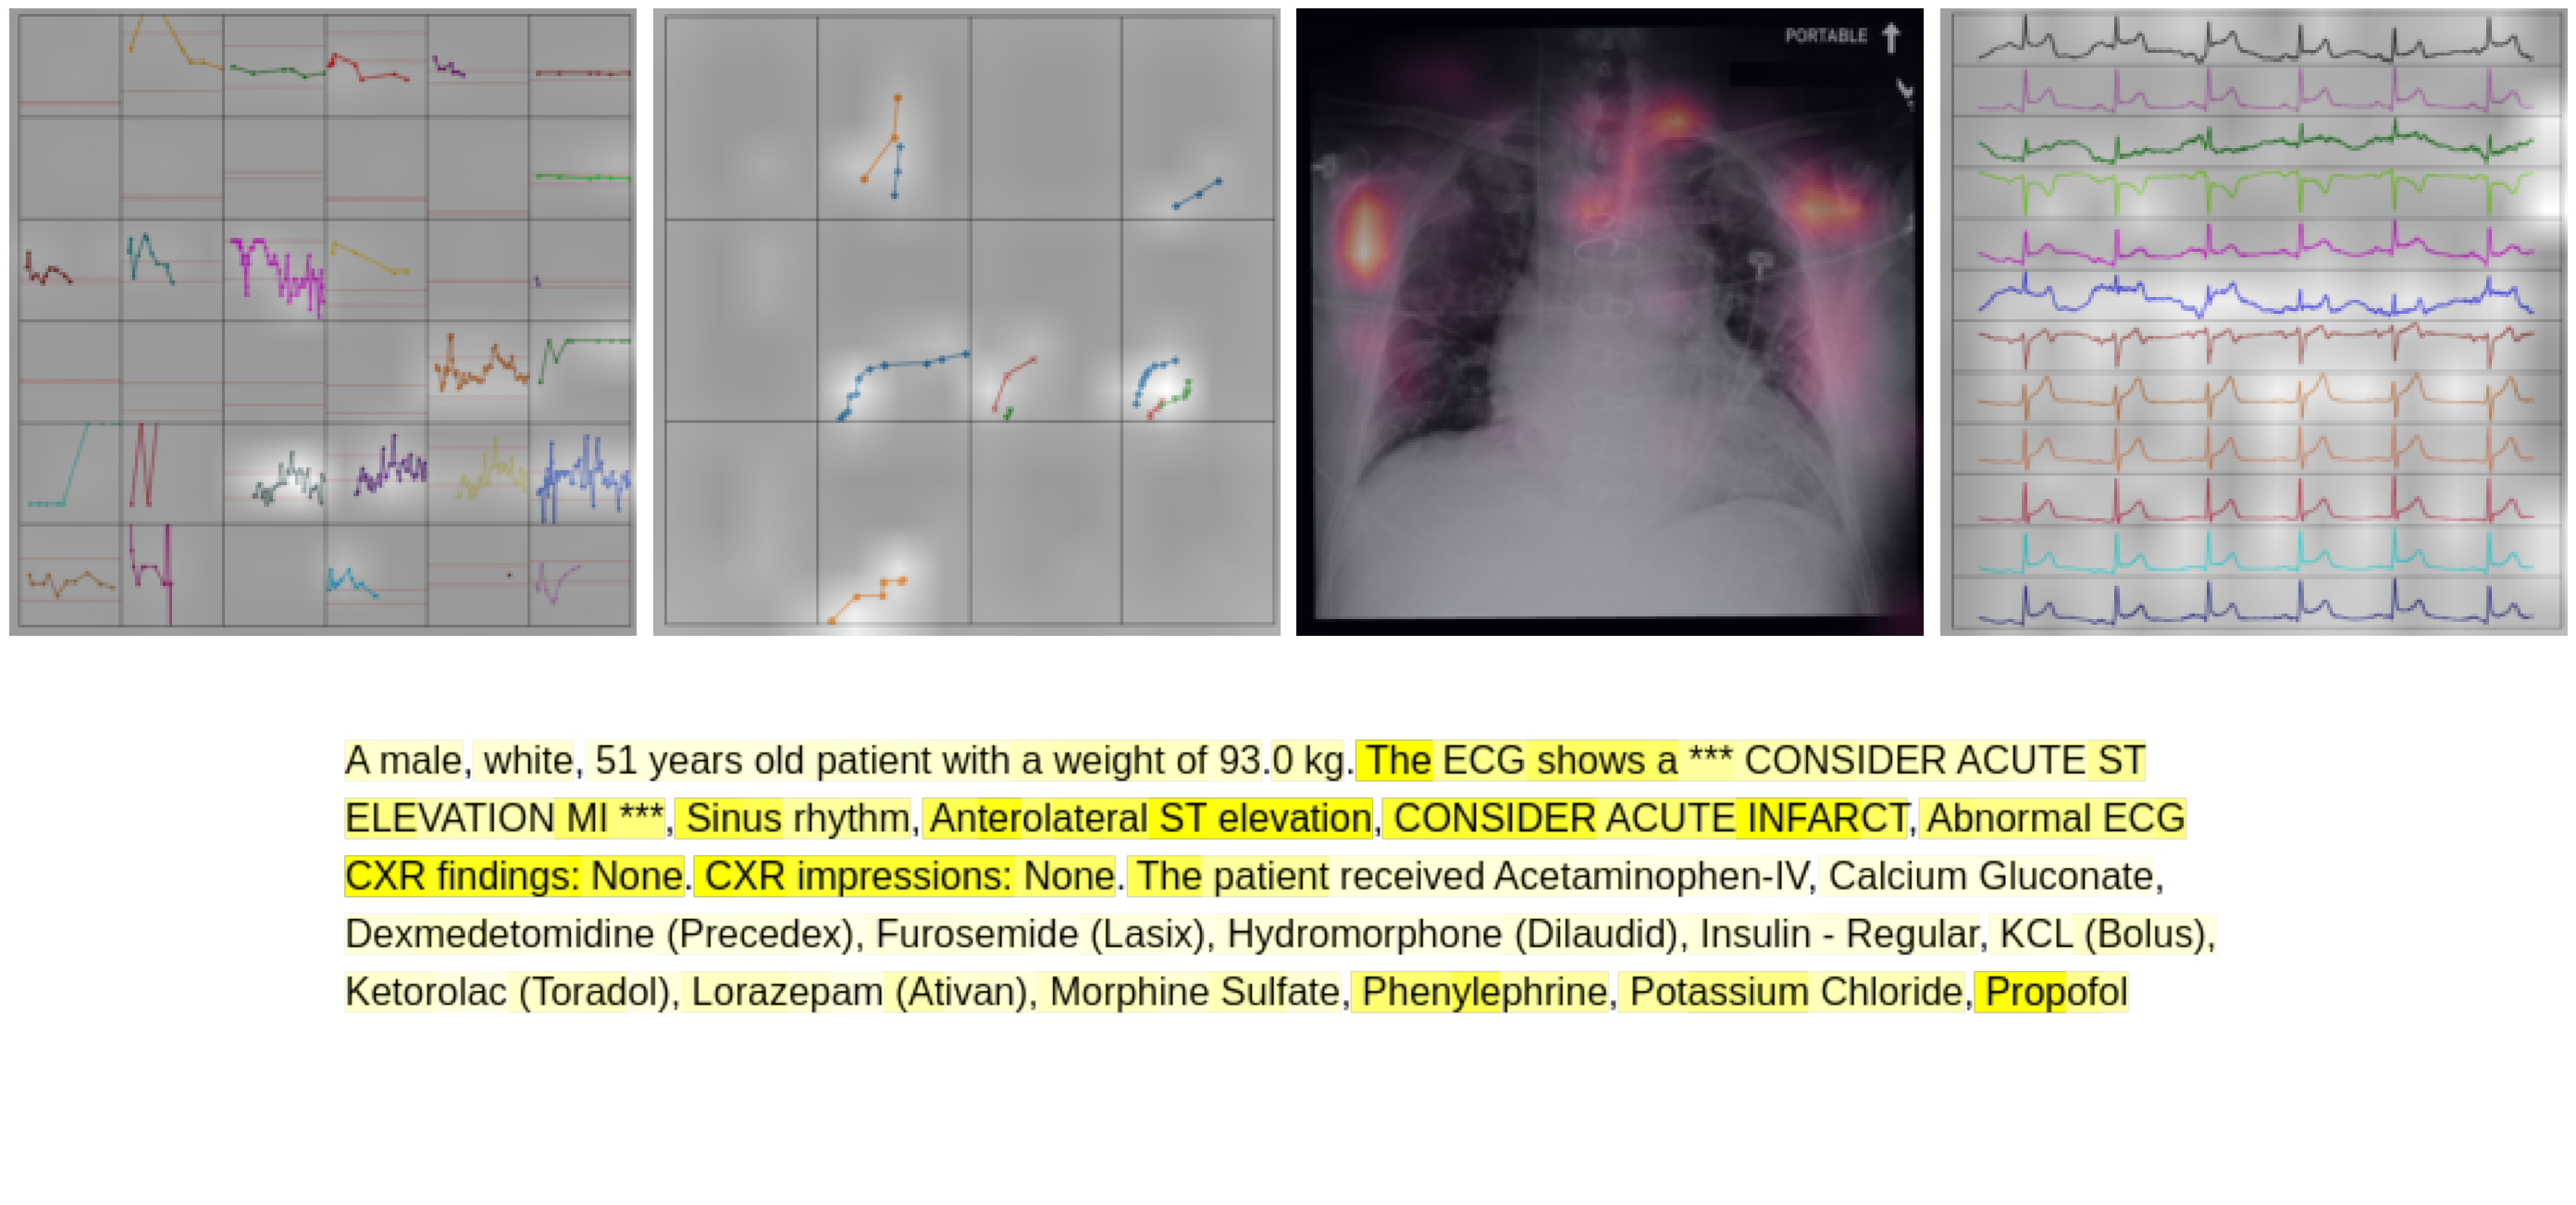

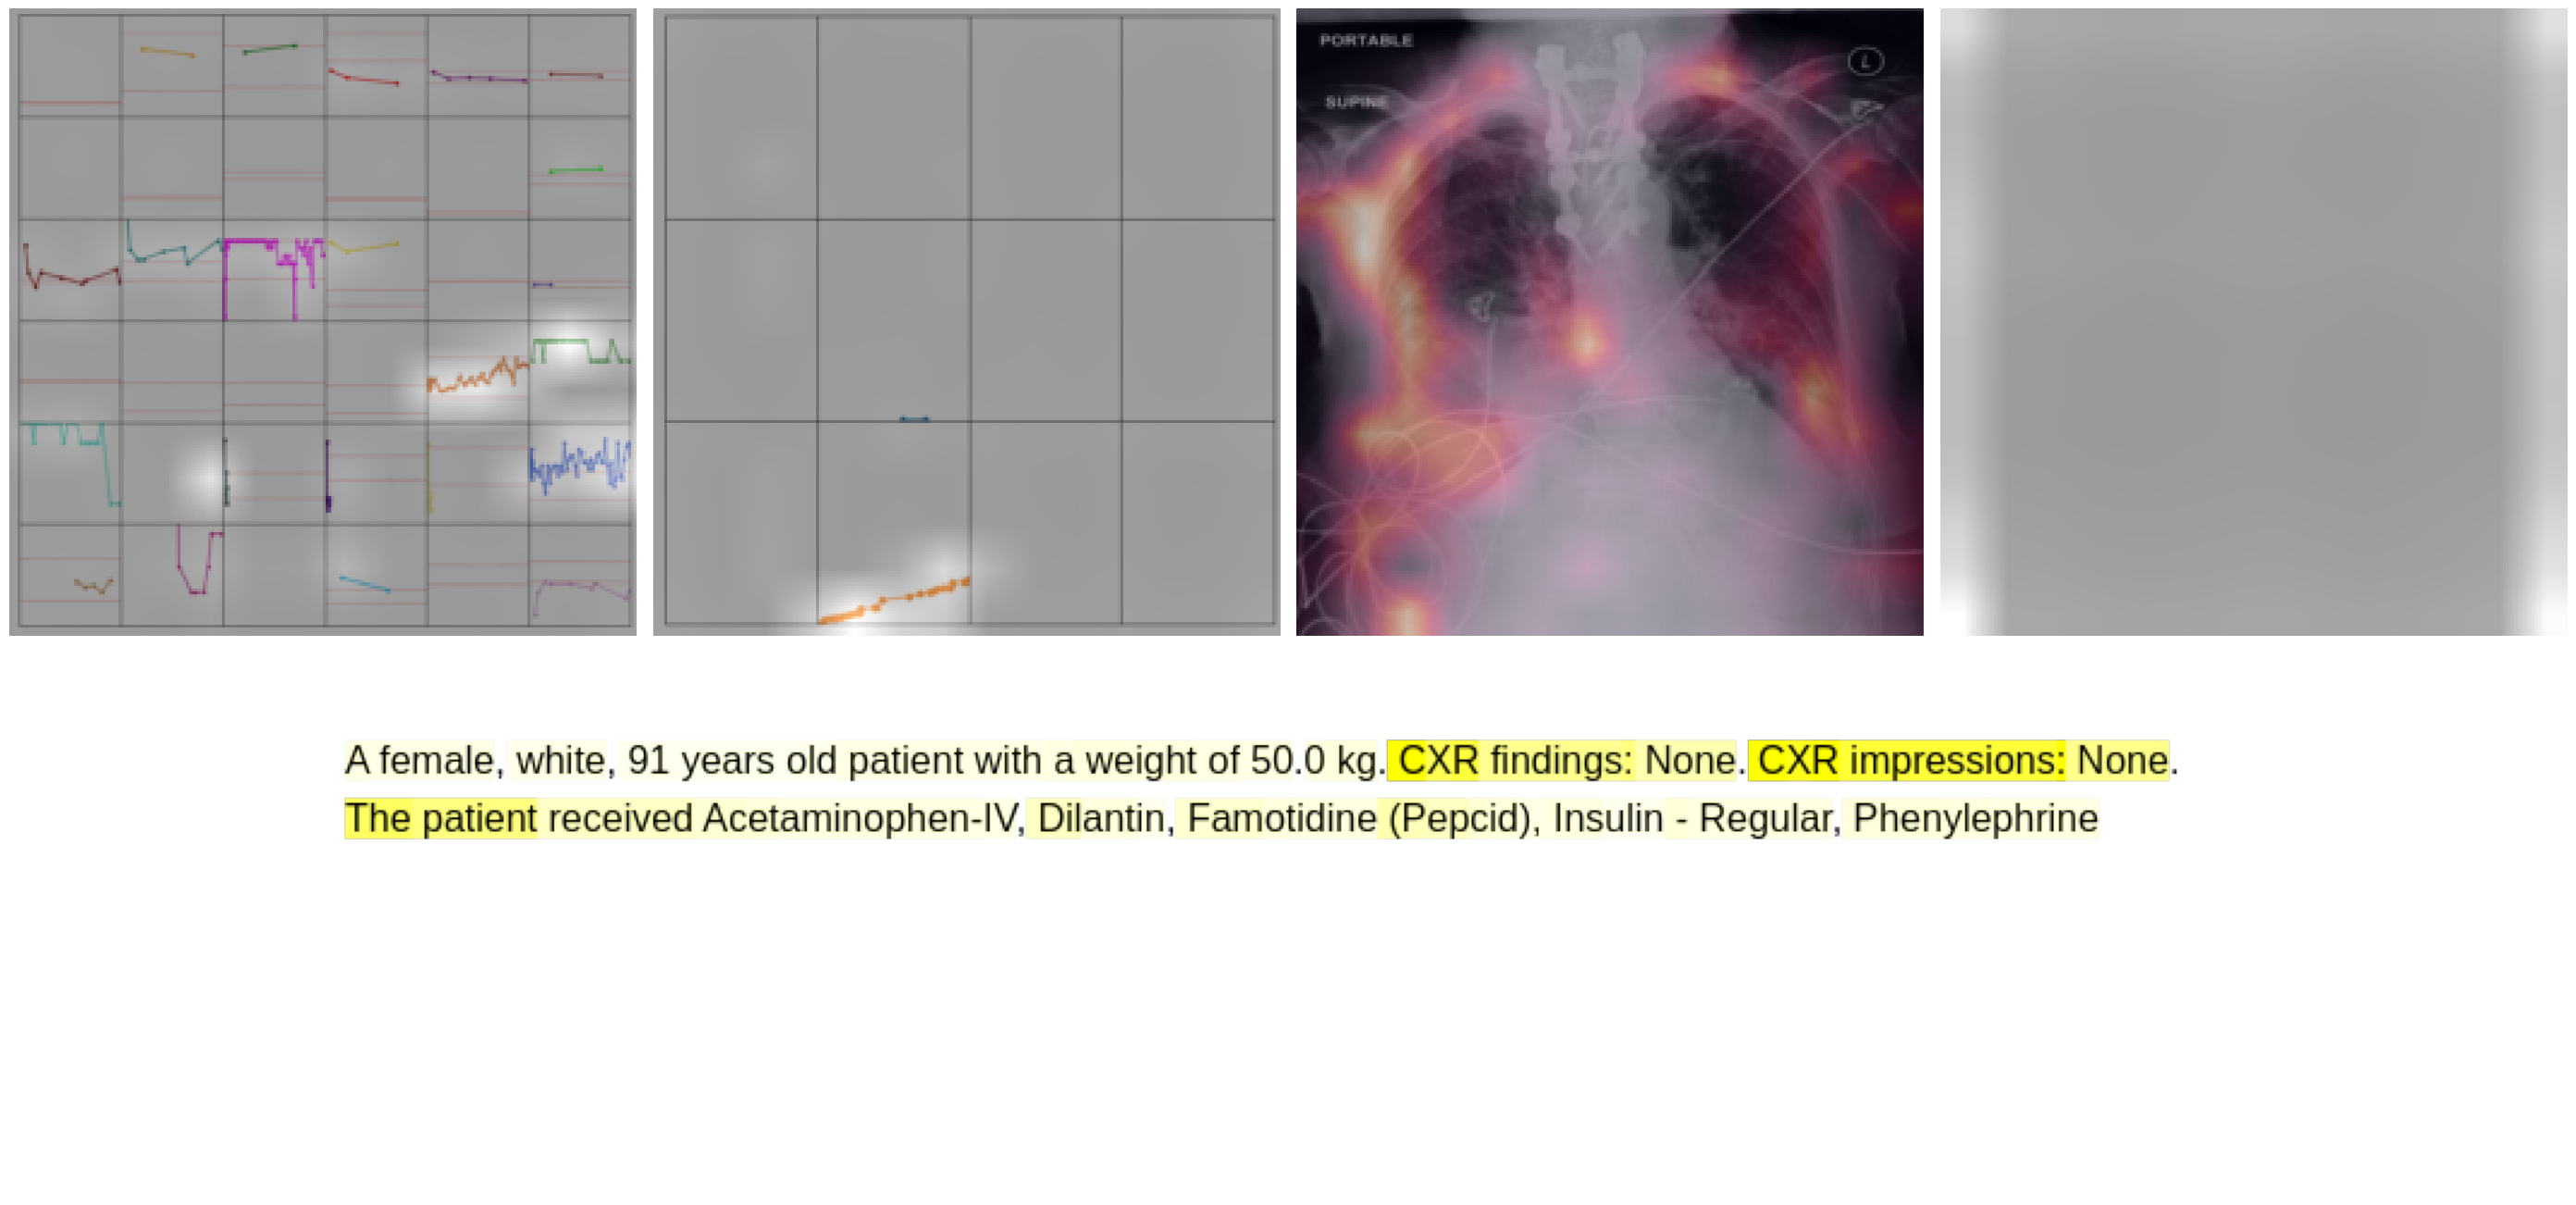

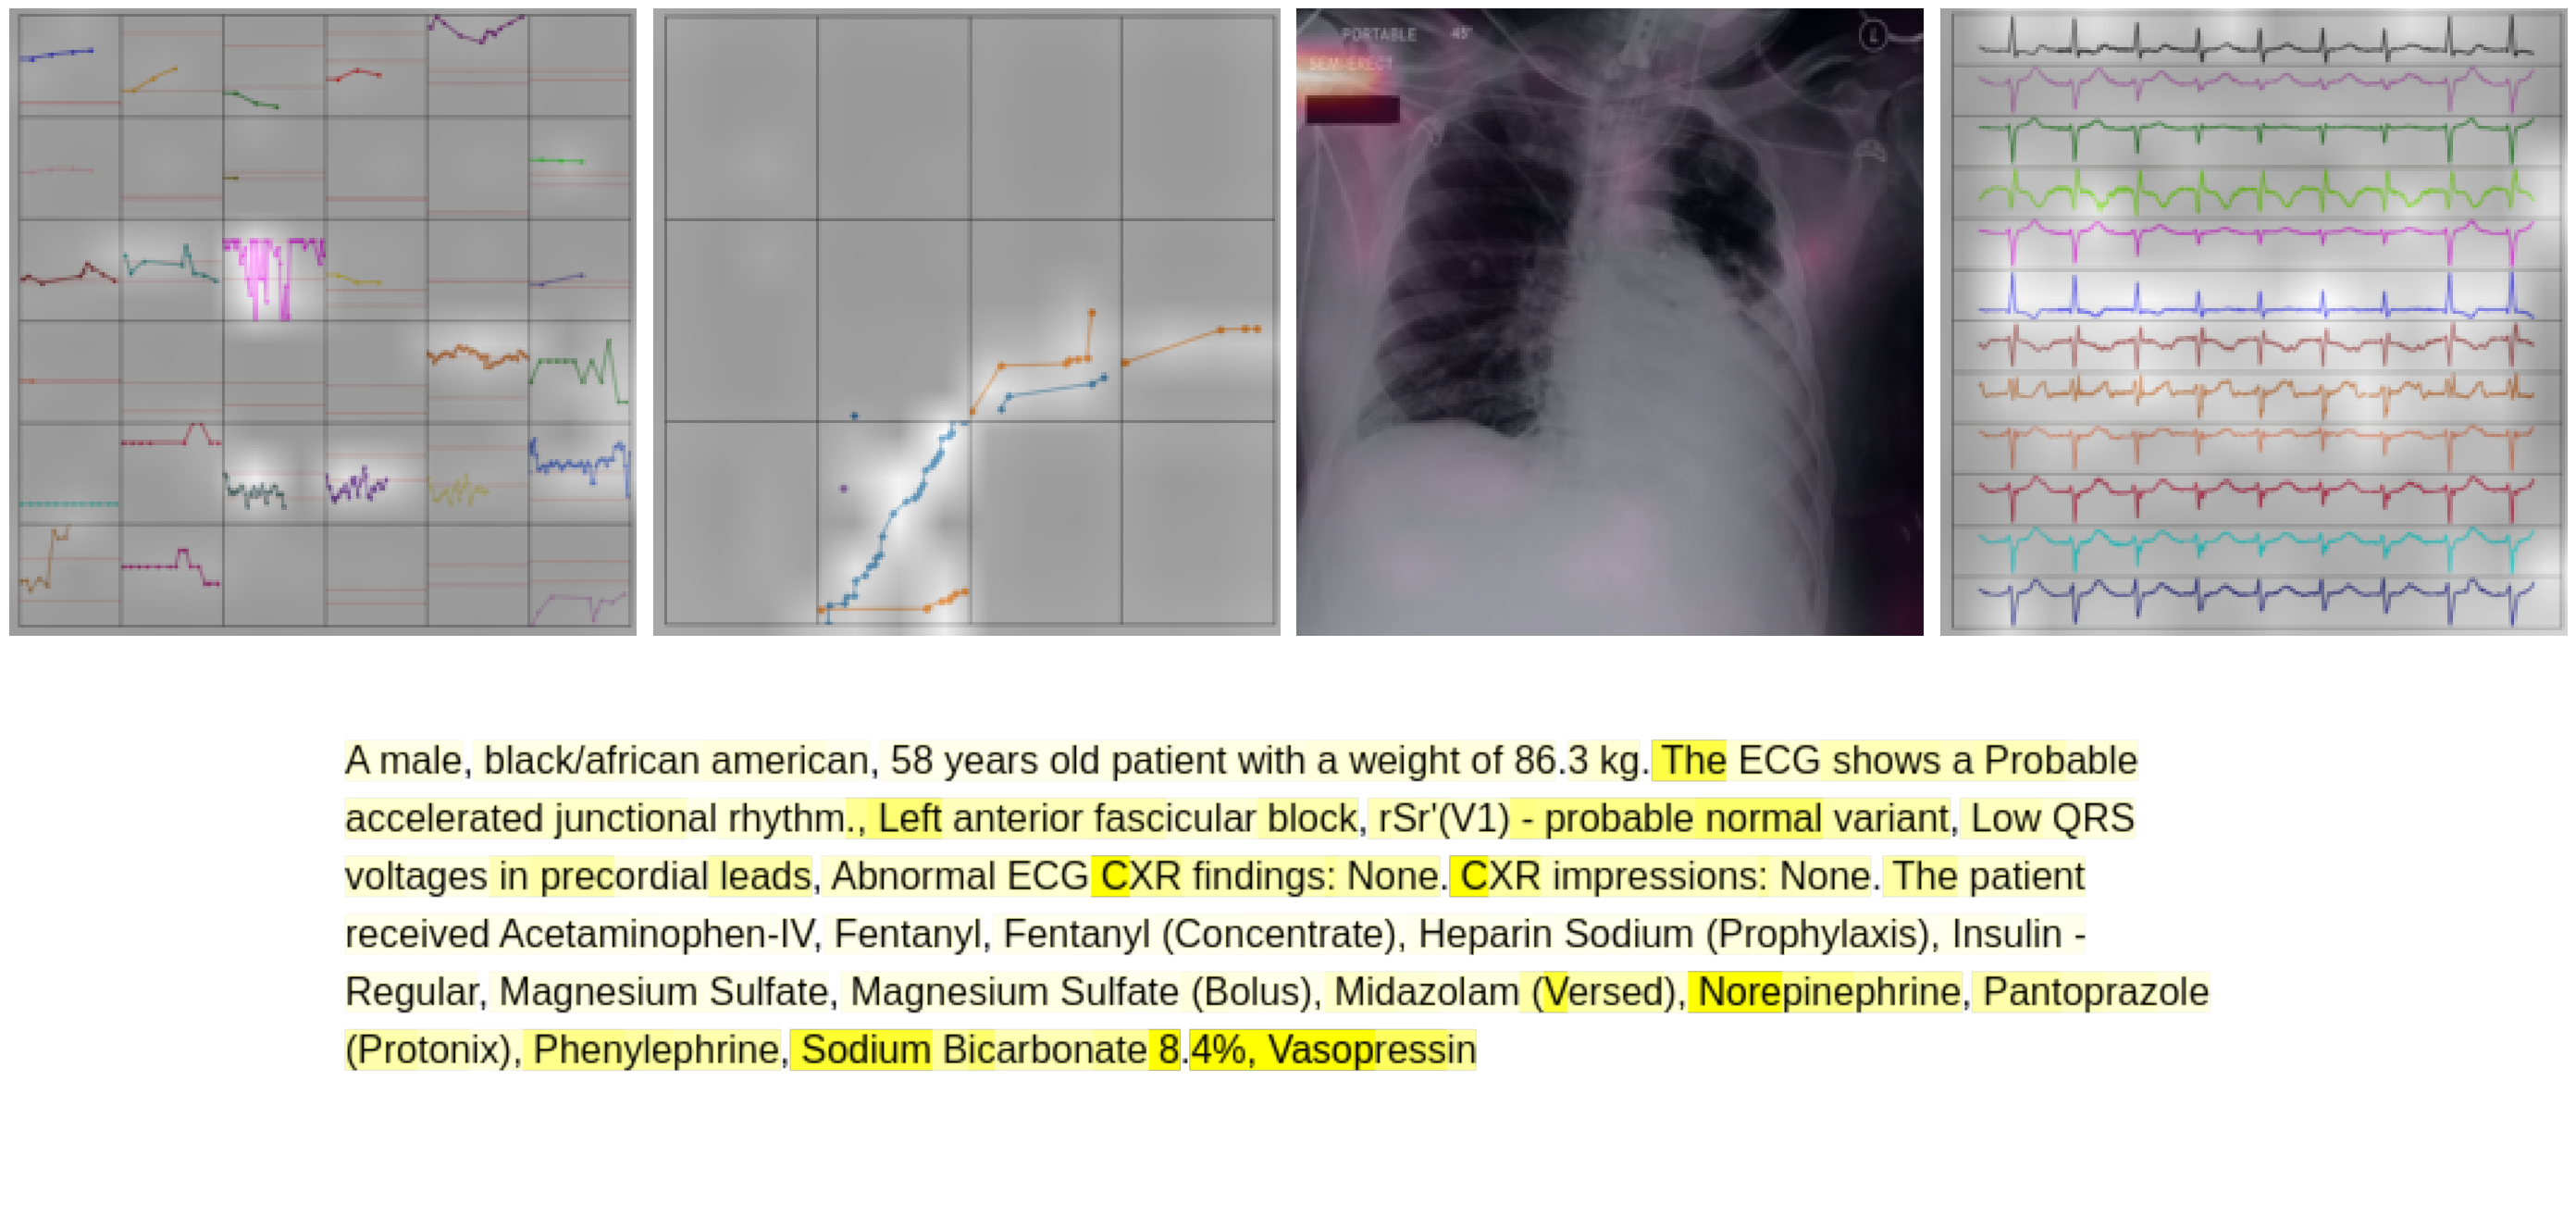

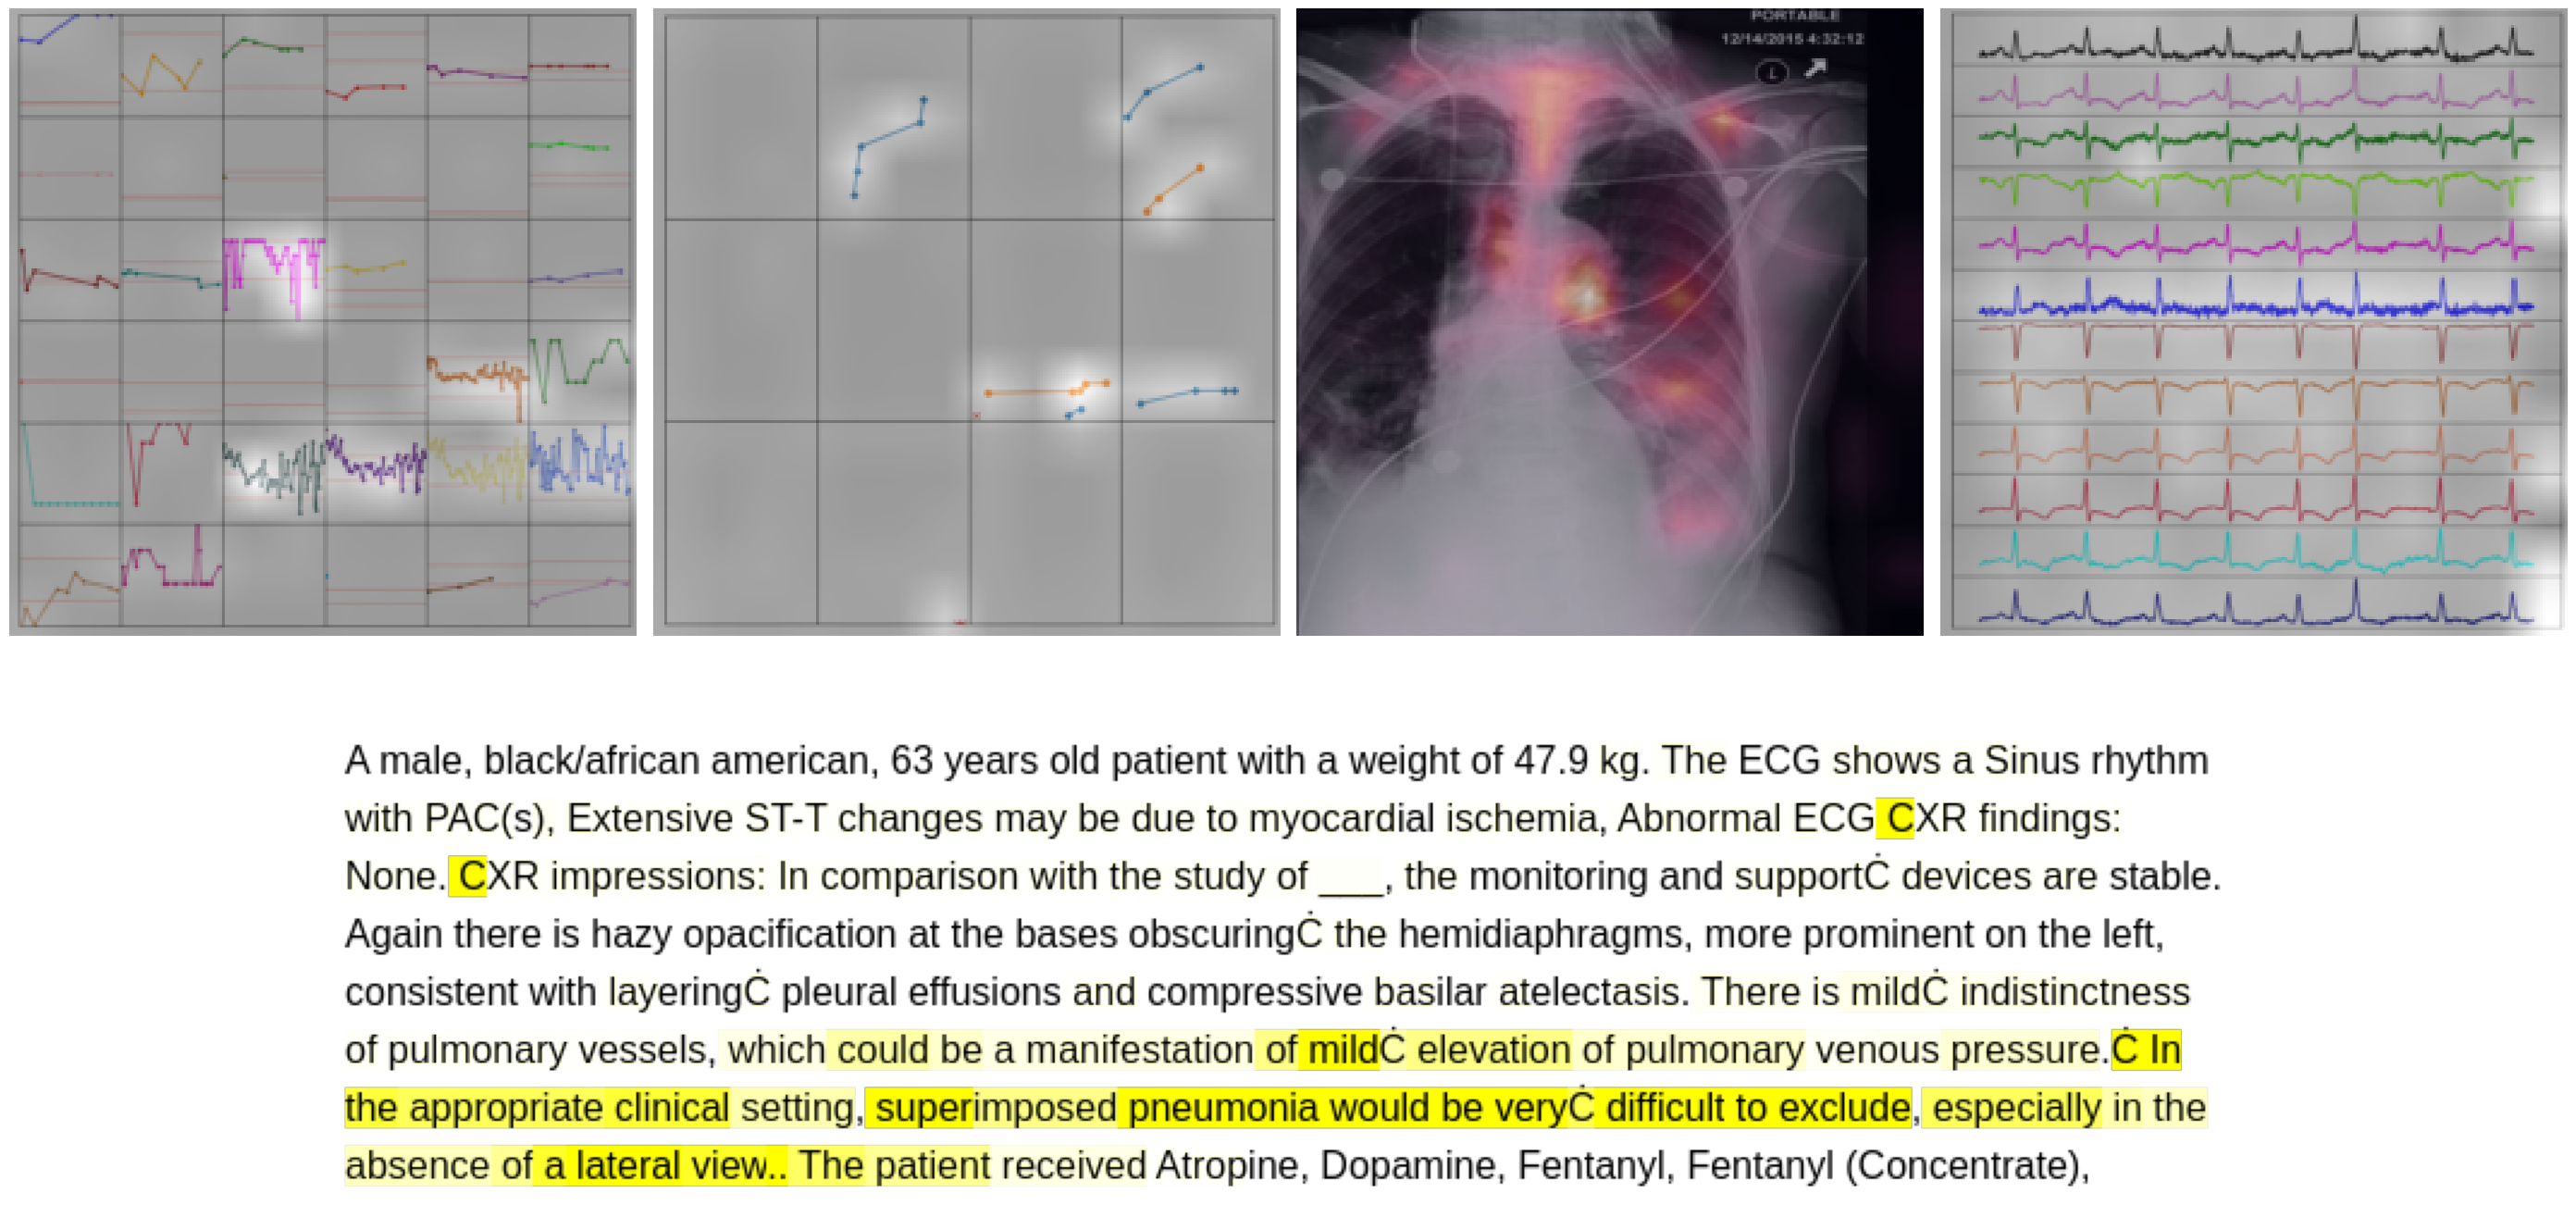

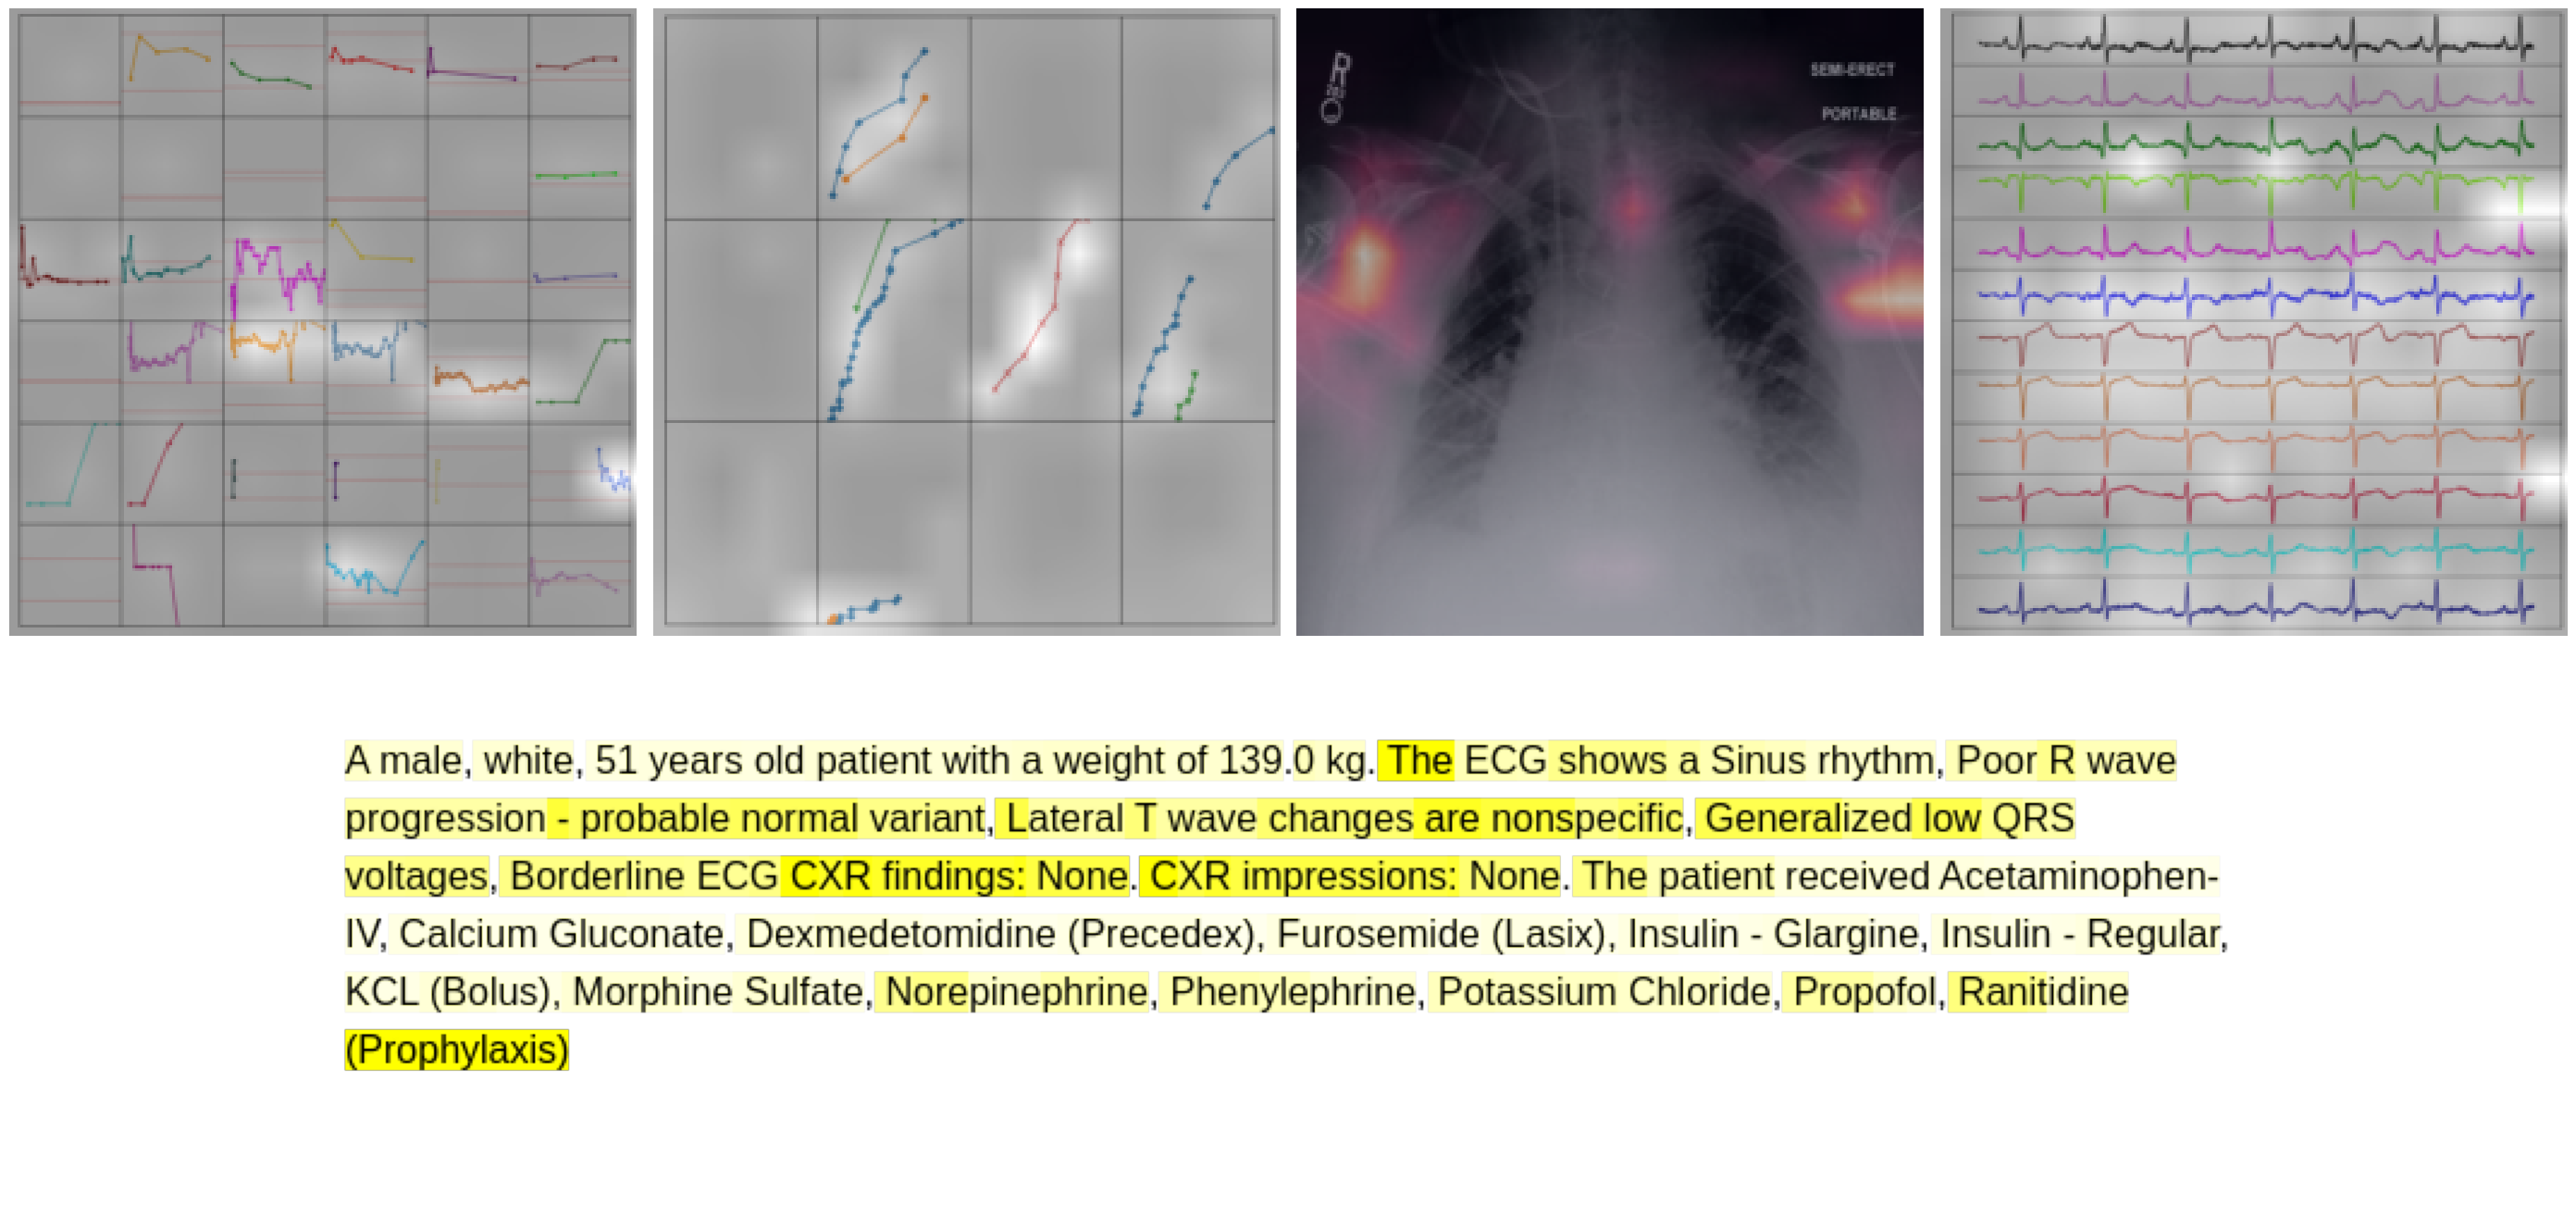

In [17]:
dst = root / 'attention_maps'
dst.mkdir(exist_ok=True)
img_model_name = 'google/vit-base-patch16-224'

for modalities in EXPERIMENTS:
    # for text_option in ['', '_text', '_text_diagnoses']:
    text_option = '_text'
    exp_name = '_'.join(modalities) + text_option
    try:
        ckpt_path = next((root / 'runs' / f'vit_{exp_name}').glob('*/checkpoint.pt'))
    except StopIteration:
        continue
    exp_dir = dst / exp_name
    exp_dir.mkdir(exist_ok=True)
    
    trainloader, valloader, testloader = dataloaders(
        task='inhospital_mortality',
        image_size=224,
        batch_size=1,
        img_model_name=img_model_name,
        modalities=modalities,
        with_diagnoses='diagnoses' in exp_name,
        root=root / 'data'
    )
    testset = testloader.dataset
    
    model = MultiModalTransformer(
        img_model_name=img_model_name,
        img_modalities=modalities,
        with_text='text' in exp_name,
        task='inhospital_mortality',
    ).to(device)
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt)
    # for i, sample in tqdm(enumerate(testset), leave=False):
    stay_ids = [
        30315583,

        30009123,
        30090650,
        30055897,

        30204754,
        30397772,
        30596506
    ]
        # if i == 10:
        #     break
        # stay_id = testset.data.iloc[i].stay_id
    for stay_id in stay_ids:
        i = np.argwhere(testset.data.stay_id==stay_id)[0,0]
        sample = testset[i]

        label = str(int(sample['y'].item()))
        (exp_dir / label).mkdir(exist_ok=True)

        s = testset.data.iloc[i]
        text = s.demographics_text
        if 'diagnoses' in text_option:
            text += ' ' + s.icd_text_inhospital_mortality
        if type(s.ecg_text) == str:
            text += ' ' + s.ecg_text
        if type(s.cxr_text) == str:
            text += ' ' + s.cxr_text
        if type(s.med_text) == str:
            text += ' ' + s.med_text
        
        fig,axs = plot_attention(
            model=model,
            sample=sample,
            img_modalities=modalities,
            with_text='text' in exp_name,
            text=text,
            layer=0,
            device=device
        )
        fig.savefig(Path('images') / label / f'{stay_id}.png', bbox_inches='tight')
        
        for i, (ax, mod) in enumerate(zip(axs, modalities + ['text'])):
            extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            fig.savefig(Path('images') / label / f'{stay_id}_{mod}.png', bbox_inches=extent)
            # break
    #     break
    # break

In [8]:
stay_id = 30315583

In [12]:
import numpy as np


array([[48]])

In [11]:
testset.data[testset.data.stay_id==stay_id]

subject_id   hadm_id   stay_id                            id_ehr  \
5473    12872916  25160311  30315583  12872916_episode4_timeseries.csv   

                                            id_cxr  \
5473  28b7d50b-1579b3a2-abf8d0dc-597ab0aa-c76ff001   

                           last_careunit               intime  \
5473  Medical Intensive Care Unit (MICU)  2139-06-04 16:02:00   

                  outtime       los            admittime  ...  \
5473  2139-06-06 20:29:33  2.185799  2139-06-04 14:20:00  ...   

     Hypertension with complications and secondary hypertension  \
5473                                                  1           

     Other liver diseases Other lower respiratory disease  \
5473                    0                               0   

     Other upper respiratory disease  \
5473                               0   

      Pleurisy; pneumothorax; pulmonary collapse  \
5473                                           0   

     Pneumonia (except that caused by tuberculosis or sexually transmitted disease)  \
5473                                                  1                               

      Respiratory failure; insufficiency; arrest (adult)  \
5473                                                  1    

      Septicemia (except in labor)  Shock  \
5473                             1      1   

                                   icd_text_phenotyping  
5473  The patient's diagnoses are Septicemia due to ...  

[1 rows x 57 columns]